<a href="https://colab.research.google.com/github/cookiesx123/wine-quality-pred/blob/main/wine_quality_pred_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import bibliotek

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Wczytanie danych

In [ ]:
df = pd.read_excel('winequality-red-final.xlsx')
df.head()

,fixed_acidity,volatile_acidity,chlorides,density,pH,sulphates,alcohol,quality
0,11.2,0.280,0.075,0.9980,3.16,0.58,9.8,6
1,6.9,0.400,0.085,0.9968,3.43,0.63,9.7,6
2,6.3,0.390,0.080,0.9955,3.34,0.56,9.3,5
3,7.6,0.410,0.080,0.9962,3.28,0.59,9.5,5
4,8.3,0.655,0.083,0.9966,3.17,0.66,9.8,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fixed_acidity     192 non-null    float64
 1   volatile_acidity  192 non-null    float64
 2   chlorides         192 non-null    float64
 3   density           192 non-null    float64
 4   pH                192 non-null    float64
 5   sulphates         192 non-null    float64
 6   alcohol           192 non-null    float64
 7   quality           192 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 12.1 KB


#Dobór zmiennych

## Metoda Quasi stałych

In [ ]:
def czy_quasi_stala(dane, prog_zmiennosci=0.5):
    srednia = np.mean(dane)
    odchylenie_std = np.std(dane)
    wspolczynnik_zmiennosci = odchylenie_std / srednia

    return wspolczynnik_zmiennosci < prog_zmiennosci

print(czy_quasi_stala(df))

fixed_acidity       True
volatile_acidity    True
chlorides           True
density             True
pH                  True
sulphates           True
alcohol             True
quality             True
dtype: bool


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Więc nie usuwamy żadnej ze zmiennych objaśniających

## Metoda analizy macierzy

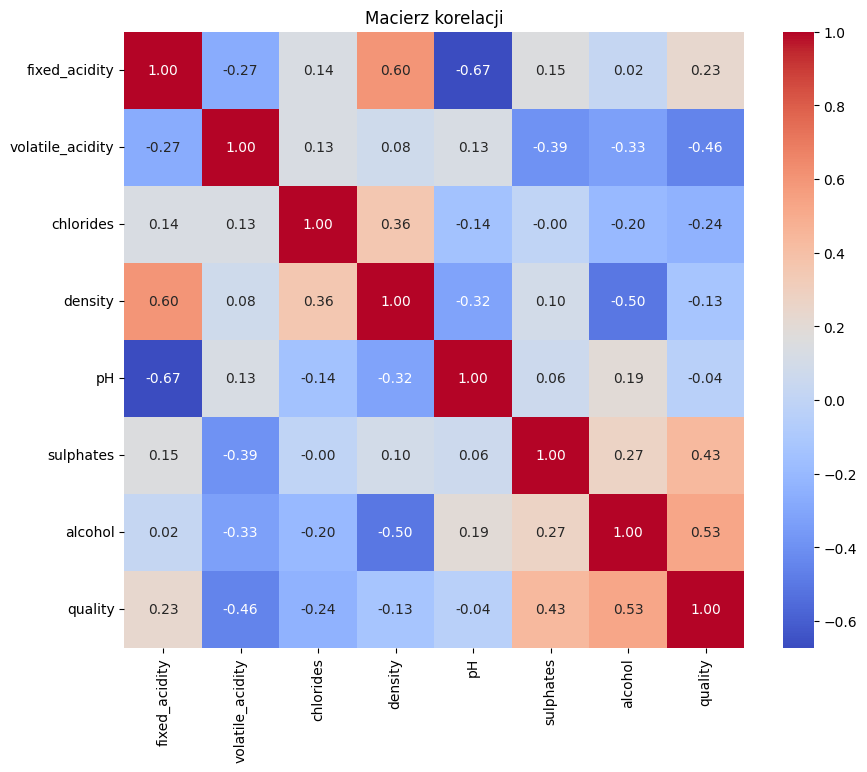

In [ ]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")#heatmap
plt.title('Macierz korelacji')
plt.show()

In [ ]:
prog = 0.14
korelacje_z_targetem = corr_matrix['quality'].drop('quality')
zmienne_istotne = korelacje_z_targetem[abs(korelacje_z_targetem) > prog].index.tolist()

print("Wybrane zmienne na podstawie macierzy korelacji")
print(zmienne_istotne)

Wybrane zmienne na podstawie macierzy korelacji
['fixed_acidity', 'volatile_acidity', 'chlorides', 'sulphates', 'alcohol']


In [ ]:
def wybierz_zmienne(df, prog_korelacji_z_targetem=0.14, prog_korelacji_miedzy_sobą=0.53)

    # Oblicz macierz korelacji
    corr_matrix = df.corr()

    # Wybierz zmienne na podstawie korelacji z targetem
    korelacje_z_targetem = corr_matrix['quality'].drop('quality')
    zmienne_istotne = korelacje_z_targetem[abs(korelacje_z_targetem) > prog_korelacji_z_targetem].index.tolist()

    # Usuń zmienne, które są zbyt mocno skorelowane ze sobą
    zmienne_do_usuniecia = []
    for i in range(len(zmienne_istotne)):
        for j in range(i + 1, len(zmienne_istotne)):
            korelacja = corr_matrix.loc[zmienne_istotne[i], zmienne_istotne[j]]
            if abs(korelacja) > prog_korelacji_miedzy_sobą:
                # Jeśli dwie zmienne są zbyt mocno skorelowane, usuń tę z mniejszą korelacją z targetem
                if abs(korelacje_z_targetem[zmienne_istotne[i]]) < abs(korelacje_z_targetem[zmienne_istotne[j]]):
                    zmienne_do_usuniecia.append(zmienne_istotne[i])
                else:
                    zmienne_do_usuniecia.append(zmienne_istotne[j])

    zmienne_wybrane = [zmienna for zmienna in zmienne_istotne if zmienna not in zmienne_do_usuniecia]

    return zmienne_wybrane

# Przykład użycia:
zmienne_wybrane = wybierz_zmienne(df)
print("Wybrane zmienne:")
print(zmienne_wybrane)

Wybrane zmienne:
['fixed_acidity', 'volatile_acidity', 'chlorides', 'sulphates', 'alcohol']


Usuwamy zmienną objaśniającą pH

In [ ]:
df=df.drop('pH', axis=1)
df=df.drop('density',axis=1)

# Obserwacje nietypowe

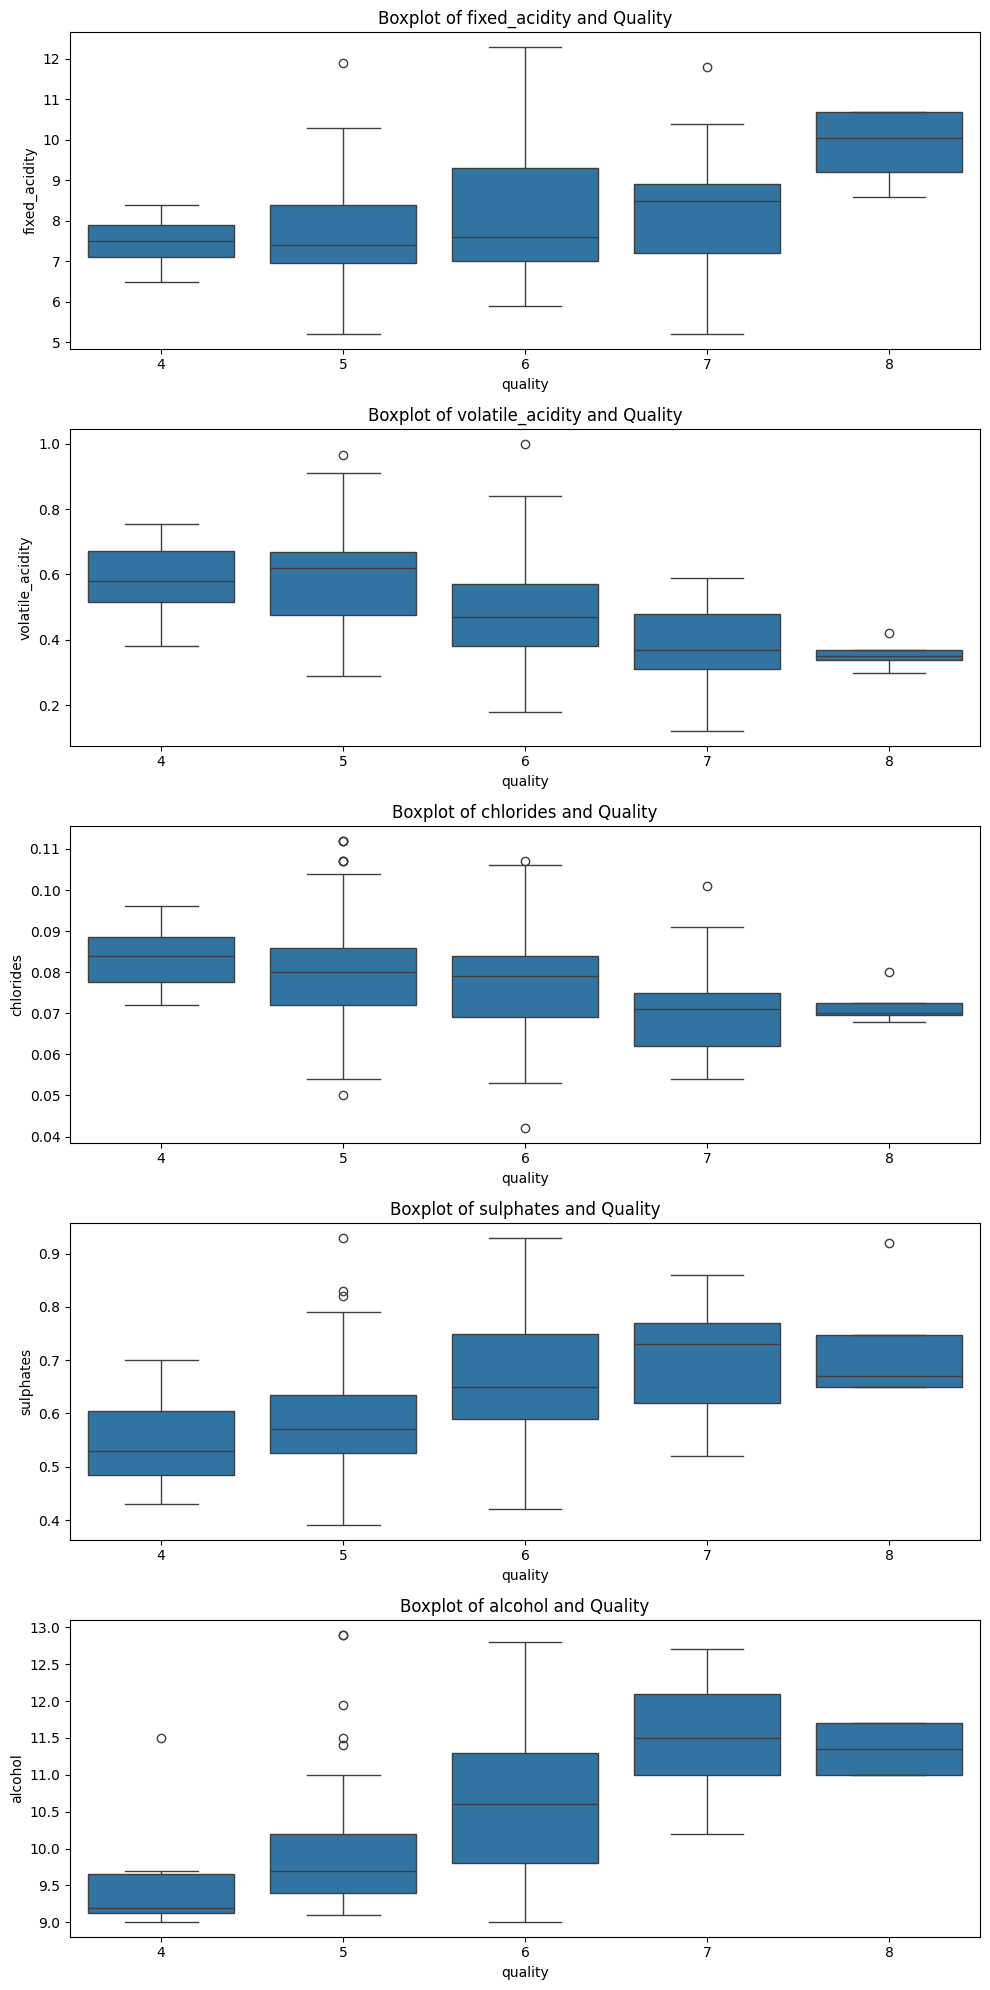

In [ ]:
numerical_features = df.select_dtypes(include=['number']).columns.drop('quality')
fig, axes = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(10, 4 * len(numerical_features)))

for i, feature in enumerate(numerical_features):
    sns.boxplot(x='quality', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature} and Quality')

plt.tight_layout()
plt.show()

In [ ]:
!pip install statsmodels==0.13.5
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
df_filtered = df.copy()
model = smf.ols('quality ~ fixed_acidity + volatile_acidity + chlorides + sulphates + alcohol', data=df).fit()
influence = model.get_influence()
leverage = influence.hat_matrix_diag
n = df.shape[0]
k = len(model.params)
high_leverage_threshold = 2 * (k + 1) / n
high_leverage_points = df[leverage > high_leverage_threshold]
print(high_leverage_points)

     fixed_acidity  volatile_acidity  chlorides  sulphates  alcohol  quality
5              5.2             0.320      0.103       0.55      9.2        5
13             7.8             0.560      0.104       0.93      9.5        5
29             8.2             1.000      0.065       0.55      9.0        6
43            10.0             0.420      0.107       0.93     11.8        6
56            10.2             0.645      0.053       0.42     10.0        6
84             7.7             0.965      0.112       0.50      9.5        5
168            5.9             0.440      0.042       0.85     11.7        6


Usuwamy zmienne odstające

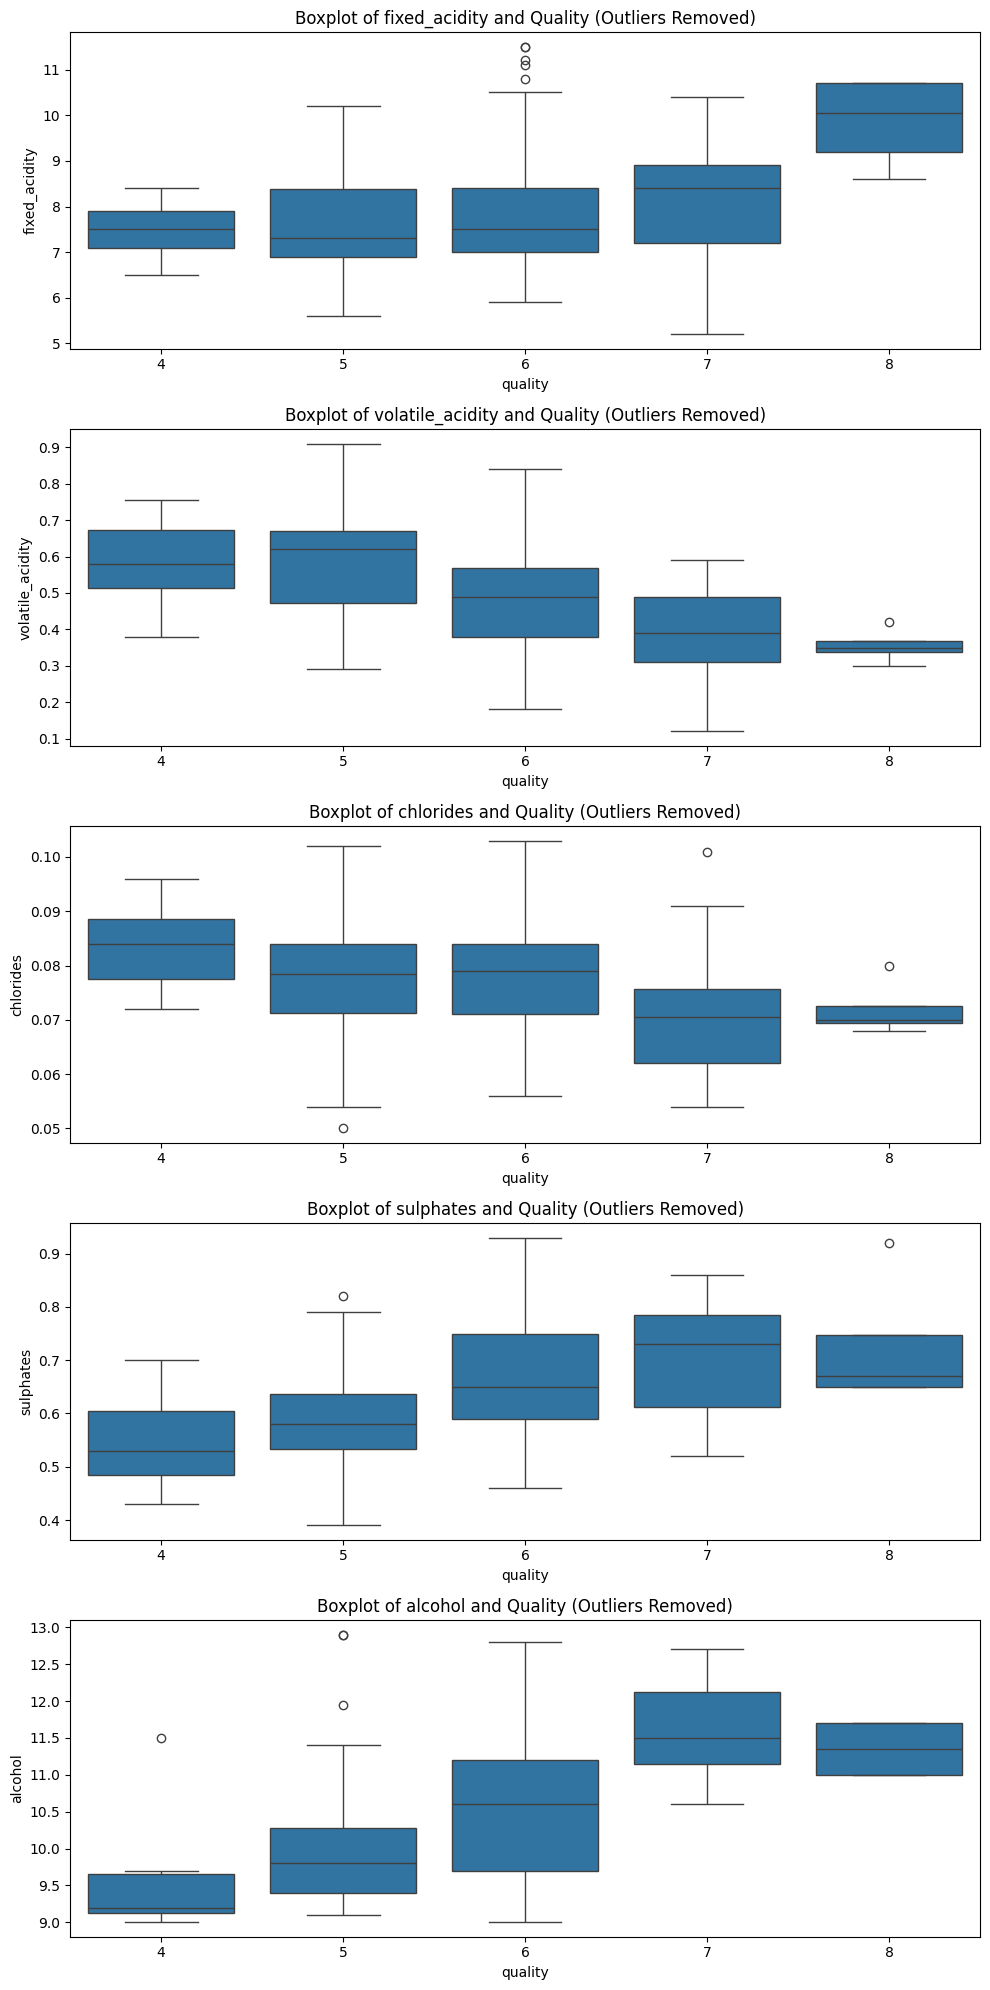

In [ ]:
numerical_features = df.select_dtypes(include=['number']).columns.drop('quality')
df = df[leverage <= high_leverage_threshold]
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data_filtered = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data_filtered

for feature in numerical_features:
    df = remove_outliers_iqr(df, feature)


fig, axes = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(10, 4 * len(numerical_features)))
for i, feature in enumerate(numerical_features):
    sns.boxplot(x='quality', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature} and Quality (Outliers Removed)')

plt.tight_layout()
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174 entries, 0 to 191
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fixed_acidity     174 non-null    float64
 1   volatile_acidity  174 non-null    float64
 2   chlorides         174 non-null    float64
 3   sulphates         174 non-null    float64
 4   alcohol           174 non-null    float64
 5   quality           174 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 9.5 KB


### Ponowny dobór zmiennych

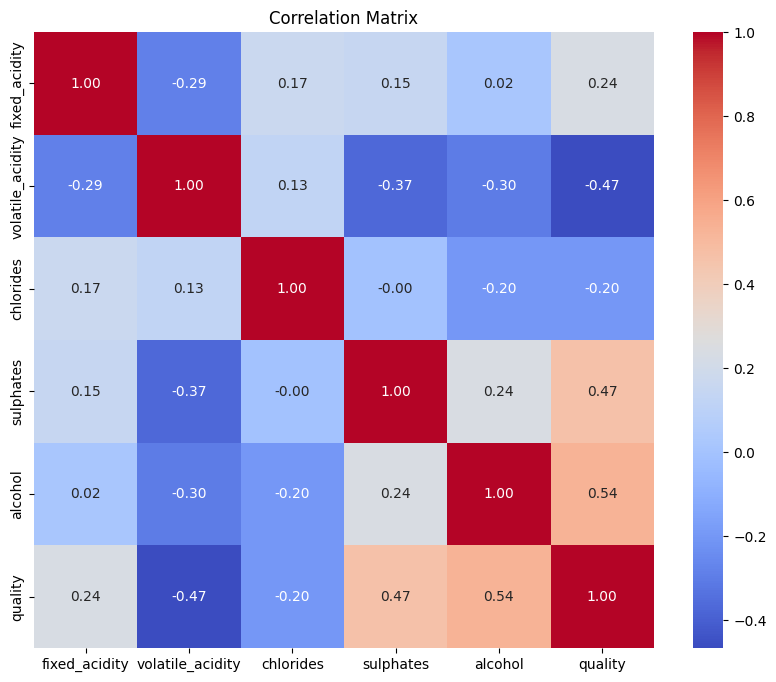

In [ ]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")#heatmap
plt.title('Correlation Matrix')
plt.show()

In [ ]:
prog = 0.05
korelacje_z_targetem = corr_matrix['quality'].drop('quality')
zmienne_istotne = korelacje_z_targetem[abs(korelacje_z_targetem) > prog].index.tolist()

print("Wybrane zmienne na podstawie macierzy korelacji")
print(zmienne_istotne)

Wybrane zmienne na podstawie macierzy korelacji
['fixed_acidity', 'volatile_acidity', 'chlorides', 'sulphates', 'alcohol']


Nie zmieniamy zestawu zmiennych objaśniających

# Badanie współliniowości

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, features):

    X = df[features]

    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif_data


numerical_features = ['fixed_acidity', 'volatile_acidity', 'chlorides', 'sulphates', 'alcohol']

vif_df = calculate_vif(df, numerical_features)
print(vif_df)

features_to_delete = vif_df[vif_df["VIF"] <= 10]["feature"].tolist()
print("\nZmienne do usunięcia:")
print(features_to_delete)

            feature        VIF
0     fixed_acidity  37.260323
1  volatile_acidity  13.062090
2         chlorides  51.881491
3         sulphates  37.887358
4           alcohol  61.092677

Zmienne do usunięcia:
[]


Również nie zmieniamy zestawu zmiennych objaśniających

In [ ]:
#df.to_excel('winequality-red-final-prepared.xlsx', index=False)

# Badanie losowości reszt

In [ ]:
import scipy.stats as stats

In [ ]:
def runs_test(data):
  n = len(data)
  median = np.median(data)
  binary_data = np.where(data >= median, 1, 0)

  runs = 0
  for i in range(n - 1):
    if binary_data[i] != binary_data[i + 1]:
      runs += 1
  runs += 1

  n1 = np.sum(binary_data)
  n2 = n - n1
  expected_runs = (2 * n1 * n2) / n + 1
  variance_runs = (2 * n1 * n2 * (2 * n1 * n2 - n)) / (n**2 * (n - 1))

  z_score = (runs - expected_runs) / np.sqrt(variance_runs)

  p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

  return z_score, p_value


residuals = model.resid
statistic, p_value = runs_test(residuals)

print('Statystyka:', statistic)
print('p-value:', p_value)

alpha = 0.05
if p_value > alpha:
  print('Brak podstaw do odrzucenia hipotezy zerowej o losowości.')
else:
  print('Odrzucamy hipotezę zerową o losowości.')

Statystyka: -1.8813197588628359
p-value: 0.05992843477662113
Brak podstaw do odrzucenia hipotezy zerowej o losowości.


# Badanie normalności reszt

In [ ]:
statistic, p_value = stats.shapiro(residuals)

print('Statystyka:', statistic)
print('p-value:', p_value)

alpha = 0.05
if p_value > alpha:
    print('Brak podstaw do odrzucenia hipotezy zerowej o normalności rozkładu.')
else:
    print('Odrzucamy hipotezę zerową o normalności rozkładu.')

Statystyka: 0.9930191149507762
p-value: 0.49531874989724123
Brak podstaw do odrzucenia hipotezy zerowej o normalności rozkładu.


# Badanie autokorelacji

In [ ]:
from statsmodels.stats.stattools import durbin_watson
dw_statistic = durbin_watson(model.resid)
print(f"Statystyka Durbin-Watson: {dw_statistic}")

Statystyka Durbin-Watson: 1.6903871033940963


In [ ]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

lm_test = acorr_breusch_godfrey(model, nlags=1)

print('Statystyka LM:', lm_test[0])
print('p-value:', lm_test[1])

alpha = 0.05
if lm_test[1] < alpha:
    print('Odrzucamy hipotezę zerową o braku autokorelacji.')
else:
    print('Brak podstaw do odrzucenia hipotezy zerowej o braku autokorelacji.')

Statystyka LM: 4.662012706637924
p-value: 0.03083702335565021
Odrzucamy hipotezę zerową o braku autokorelacji.


# Badanie homoskedastyczności

In [ ]:
import statsmodels.stats.diagnostic as smd
white_test = smd.het_white(model.resid, model.model.exog)
labels = ['Test statystyczny', 'p-value', 'Statystyka F', 'P-value F']
print(dict(zip(labels, white_test)))
alpha = 0.05
if p_value > alpha:
  print('Brak podstaw do odrzucenia hipotezy zerowej o homoskedastyczności.')
else:
  print('Odrzucamy hipotezę zerową o homoskedastyczności - występuje heteroskedatyczność.')

{'Test statystyczny': 17.588249741565825, 'p-value': 0.6145119316994498, 'Statystyka F': 0.8622098859025454, 'P-value F': 0.6348530283065682}
Brak podstaw do odrzucenia hipotezy zerowej o homoskedastyczności.
